In [ ]:
#install kaggle
!pip install kaggle
# Upload file
from google.colab import files
files.upload()
# Make dir for kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Kaggel API for dataset
! kaggle datasets download -d adityajn105/flickr8k

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [01:01<00:00, 16.4MB/s]
100% 1.04G/1.04G [01:01<00:00, 18.1MB/s]


In [ ]:
# Unzipping
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

Checking the size of images

In [ ]:
# Finding the shape of image
import cv2
import os
for i, image in enumerate(os.listdir('/content/Images')):
  img_path = os.path.join('/content/Images', image)
  img = cv2.imread(img_path)
  print(f"Image {i} Shape : {img.shape}")
  if i == 10:
    break

Image 0 Shape : (375, 500, 3)
Image 1 Shape : (375, 500, 3)
Image 2 Shape : (331, 500, 3)
Image 3 Shape : (333, 500, 3)
Image 4 Shape : (375, 500, 3)
Image 5 Shape : (375, 500, 3)
Image 6 Shape : (375, 500, 3)
Image 7 Shape : (372, 500, 3)
Image 8 Shape : (400, 500, 3)
Image 9 Shape : (500, 375, 3)
Image 10 Shape : (500, 334, 3)


Importing the model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print (model.summary())

553467096/553467096 [==============================] - 30s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
from tqdm import tqdm
features = {}

for image in tqdm(os.listdir('/content/Images')):
  if image.endswith('.jpg') or image.endswith('.png'):
    img_path = os.path.join('/content/Images', image)
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    image_id = image.split('.')[0]
    features[image_id] = model.predict(img_array.reshape(1, 224, 224, 3), verbose=0)


100%|██████████| 8091/8091 [12:18<00:00, 10.95it/s]


In [ ]:
features['1000268201_693b08cb0e'].shape

(1, 4096)

In [ ]:
import pickle
with open('features.pkl', 'wb') as f:
  pickle.dump(features, f)

In [ ]:
import pickle
with open('features.pkl', 'rb') as f:
  features = pickle.load(f)

In [ ]:
with open('/content/captions.txt', 'r') as file:
    captions = file.read()


In [ ]:
captions

'image,caption\n1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n10026741

Making a dictonary with key as image name and captions as value


In [ ]:
from tqdm import tqdm
mapping = {}

for text in tqdm(captions.split('\n')):
  tokens = text.split(',')
  if len(tokens) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = ' '.join(caption)
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

print("\n Total size of mappings : ", len(mapping))

# First text in document is title of .txt file which need to be removed.
del mapping['image']

print("\n Total size of mappings : ", len(mapping))


100%|██████████| 40457/40457 [00:00<00:00, 309520.91it/s]


 Total size of mappings :  8092

 Total size of mappings :  8091


Removeing all special charactors and extra spaces from captions

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [ ]:
# Making all_captions for using it in tokenizing the words
all_captions = []

for key in mapping:
  for caption in mapping[key]:
      all_captions.append(caption)

print(all_captions)
print('Length of captions : ', len(all_captions))

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq', 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow

Tokenizing the sentenses

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Total Unique words/Vocab size: ", vocab_size)
max_len_cap = max(len(caption.split()) for caption in all_captions)
print('Max lenght of caption: ', max_len_cap)

Total Unique words/Vocab size:  8485
Max lenght of caption:  35


In [ ]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'a': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
# Making data generator function

def data_generator(image_id, captions_mapping, image_features, tokenizer, batch_size, max_length, vocab_size):
  image_fet, seq_input_text, y_output = [], [], []
  n = 0
  while True:
    for key, captions in captions_mapping.items():
      n += 1

      for capt in captions:
        seq = tokenizer.texts_to_sequences([capt])[0]

        for i in range(1, len(seq)):
          input_seq, output_seq = seq[:i], seq[i]
          input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
          output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

          image_fet.append(image_features[key][0])
          seq_input_text.append(input_seq)
          y_output.append(output_seq)

      if n == batch_size:
        image_fet, seq_input_text, y_output = np.array(image_fet), np.array(seq_input_text), np.array(y_output)
        yield [image_fet, seq_input_text], y_output
        image_fet, seq_input_text, y_output = [], [], []
        n = 0

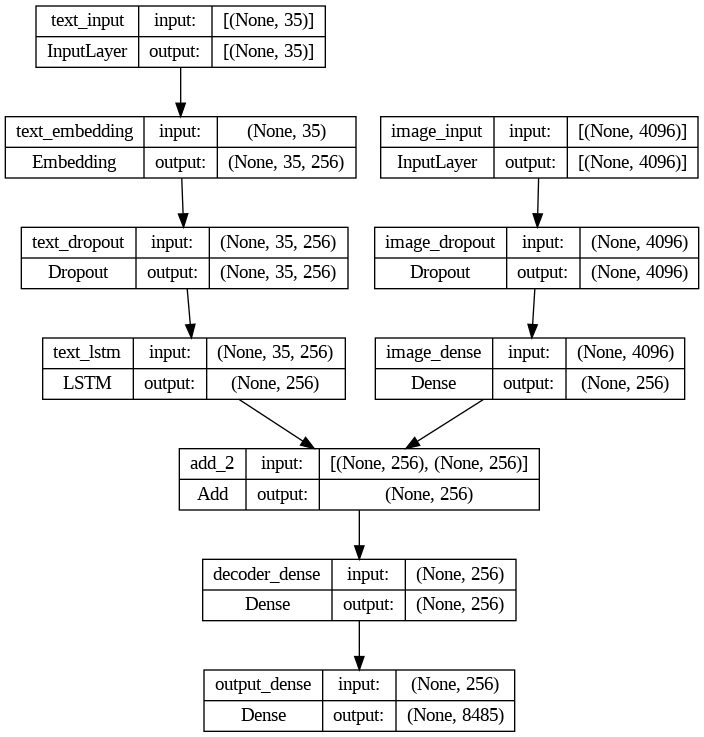

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, concatenate, Add
from tensorflow.keras.utils import plot_model

# Image model layers
input1 = Input(shape=(4096,), name="image_input")
fe1 = Dropout(0.4, name="image_dropout")(input1)
fe2 = Dense(256, activation='relu', name="image_dense")(fe1)

# Text model layers
input2 = Input(shape=(max_len_cap,), name="text_input")
se1 = Embedding(vocab_size, 256, mask_zero=True, name="text_embedding")(input2)
se2 = Dropout(0.4, name="text_dropout")(se1)
se3 = LSTM(256, return_sequences=False, name="text_lstm")(se2)

# decoder model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu', name="decoder_dense")(decoder1)
outputs = Dense(vocab_size, activation='softmax', name="output_dense")(decoder2)

# defining the model
model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_weights_only=False, save_best_only=True, verbose=1)

# Training of Model
epochs = 10
batch_size = 32
steps = len(mapping.keys()) // batch_size

for epoch in range(epochs):
    # Create data generator
    generator = data_generator(
        image_id=list(mapping.keys()),
        captions_mapping=mapping,
        image_features=features,
        tokenizer=tokenizer,
        max_length=max_len_cap,
        vocab_size=vocab_size,
        batch_size=batch_size
    )

    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])

    # Save the model manually (if needed)
    model.save(f'model_epoch_{epoch + 1}.h5')


252/252 [==============================] - ETA: 0s - loss: 5.1287

252/252 [==============================] - 89s 331ms/step - loss: 5.1287


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


252/252 [==============================] - ETA: 0s - loss: 3.9410

252/252 [==============================] - ETA: 0s - loss: 3.5399

252/252 [==============================] - ETA: 0s - loss: 3.2783

252/252 [==============================] - ETA: 0s - loss: 3.0860

252/252 [==============================] - ETA: 0s - loss: 2.9429

252/252 [==============================] - ETA: 0s - loss: 2.8363

252/252 [==============================] - ETA: 0s - loss: 2.7437

252/252 [==============================] - ETA: 0s - loss: 2.6657

252/252 [==============================] - ETA: 0s - loss: 2.5951

252/252 [==============================] - 82s 325ms/step - loss: 2.5951


Function to return word for highest prbable index predictions

In [ ]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_len_cap)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog stands outside while it snows endseq
startseq dog is looking at something near the water endseq
startseq furry dog attempts to dry itself by shaking the water off its coat endseq
startseq white and brown dog shaking its self dry endseq
startseq the large brown and white dog shakes off water endseq
--------------------Predicted--------------------
startseq brown and white dog shakes itself dry on the beach endseq


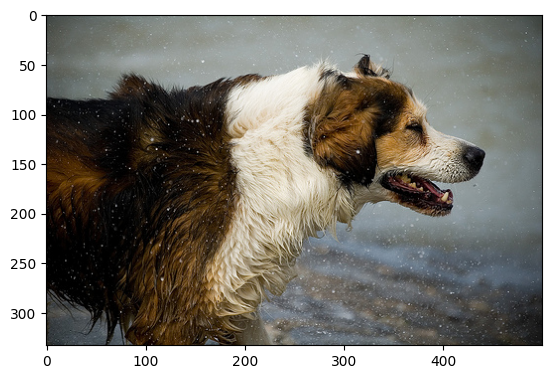

In [ ]:
generate_caption("1131800850_89c7ffd477.jpg")